## MI 5

## BCCN MI 2022

## 1. Cross-validation




In [ ]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from google.colab import files
uploaded = files.upload()





Saving TrainingRidge.csv to TrainingRidge.csv
Saving ValidationRidge.csv to ValidationRidge.csv


In [ ]:
data_train = np.array(pd.read_csv('TrainingRidge.csv'))
data_valid = np.array(pd.read_csv('ValidationRidge.csv'))

### Preprocessing

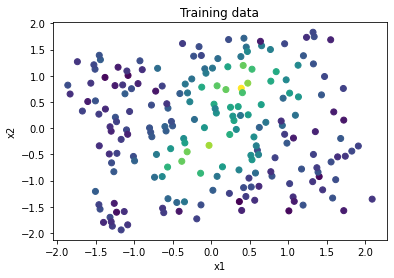

In [ ]:
def preprocessing (x,x_v):
    
    #centering the data
    x1 = x[0] - np.mean(x[0])
    x2 = x[1] - np.mean(x[1])
    x1_v = x_v[0] - np.mean(x[0])
    x2_v = x_v[1] - np.mean(x[1])

    #getting the covariance matrix and its eigenvalues and eigenvectors
    C = np.cov(x1,x2)
    E_values,E_vectors = LA.eig(C)

    #final sphering matrix
    x_sphering = np.dot(np.diag(np.power(E_values, -1/2)), E_vectors.T) 
    
    #sphering the data
    x = [x1,x2]
    x_v =[x1_v,x2_v]
    x_s = np.dot(x_sphering,x)
    x_s_v = np.dot(x_sphering,x_v)
    
    return x_s,x_s_v




x = [data_train[:,0],data_train[:,1]]
y_T = data_train[:,2]
x_v = [data_valid[:,0],data_valid[:,1]]
y_T_v = data_valid[:,2]

x_s,x_s_v = preprocessing(x,x_v)


plt.scatter(x_s[0], x_s[1],c=y_T)
plt.title('Training data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

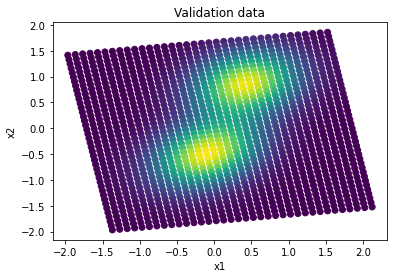

In [ ]:
plt.scatter(x_s_v[0],x_s_v[1], c = y_T_v)
plt.title('Validation data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### Feature expansion

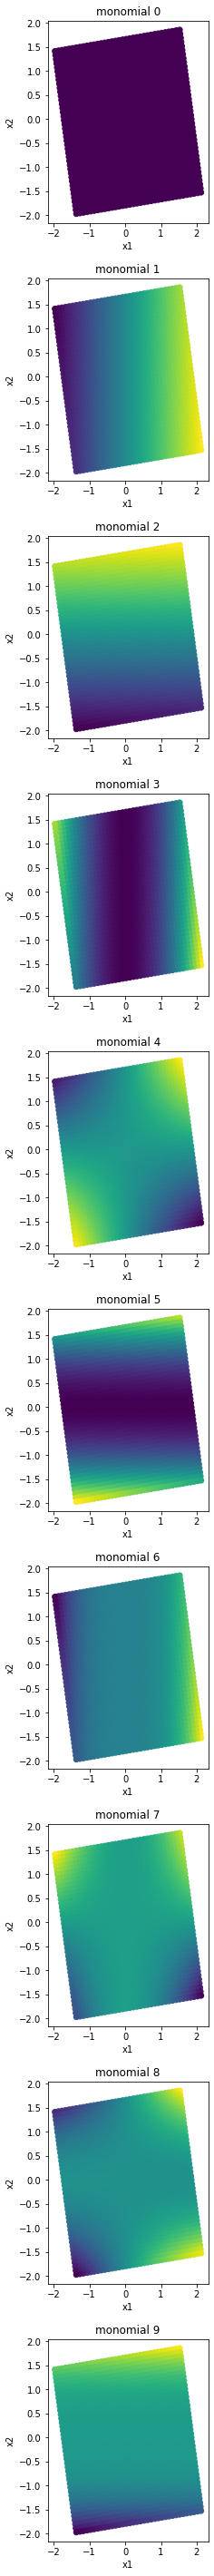

In [ ]:
def monomials(x1,x2,degree):
    phi = []
    for k in range(degree):
        for i in range (k+1) :
            phi.append((np.power(x1,k-i)*np.power(x2,i)))
    return np.array(phi)

def plotting(x,phi):
    fig,ax = plt.subplots(nrows = 10, figsize=(4,40))
    fig.tight_layout(pad =4)
    
    for i in range (10):
        ax[i].scatter(x[0], x[1], c = phi[i])
        ax[i].set_title('monomial '+str(i))
        ax[i].set_xlabel('x1')
        ax[i].set_ylabel('x2')
    
    plt.show()
    return 
    
phi = monomials(x_s[0],x_s[1],10)
phi_v  = monomials(x_s_v[0],x_s_v[1],10)
    
plotting(x_s_v, phi_v)

(55,)


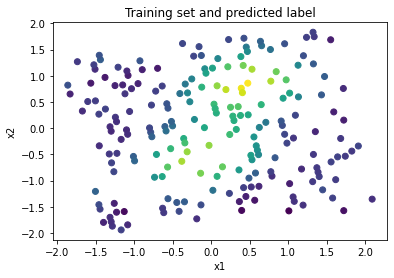

In [ ]:
w_star = np.dot(LA.inv(np.dot(phi,phi.T)),np.dot(phi,y_T.T)) #best weight calculated with phi and the true labels

prediction_function = lambda w,phi : np.dot(w.T,phi)

y = prediction_function(w_star,phi)
plt.scatter(x_s[0],x_s[1],c=y)
plt.title('Prediction of the network on the training set')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()



The neuron is performing very well on the training data

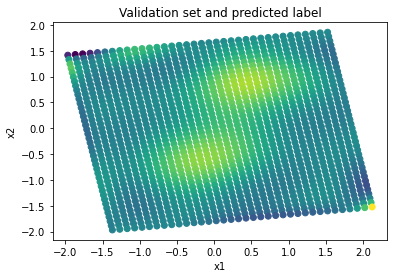

In [ ]:
y_v = prediction_function(w_star,phi_v)

plt.scatter(x_s_v[0],x_s_v[1],c=y_v)
plt.title('Prediction of the neuron on the validation set')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()


But the neuron is not performing well on the validation data : It is overfitting

## C) Regularization using a weight decay term

### i) Defining the cross validation


In [ ]:
MSE_calc = lambda y,y_hat : (1/len(y))*np.sum(np.power(y-y_hat,2))

def cross_valid (phi,y):
    MSE_average = []
    MSE_sd = []

    datasize = len(phi.T)
    step = int(0.1*datasize)
    
    lambda_L = np.power(10,np.arange(0,4,0.1))
    lambda_L = np.append((1/lambda_L),lambda_L)
    lambda_L = np.sort(lambda_L)

    for lama in lambda_L:
      MSE_local = []
      for i in np.arange(0,datasize, step):

        #splitting the data in train and test set
        phi_test = phi.T[i:i +step].T  
        y_test = y[i : i +step]
        phi_train = np.append(phi.T[0:i ], phi.T[i+step:], axis=0)
        phi_train = phi_train.T
        y_train = np.append(y.T[0:i ], y.T[i+step:],axis=0)
        y_train = y_train.T

        #calculating the best weight for this train set and this lambda
        I = np.identity(len(phi_train)) 
        weight_star = np.dot(LA.inv(np.dot(phi_train,phi_train.T)+ np.dot(lama,I)),np.dot(phi_train,y_train.T))
        
        #testing the prediction on the test set
        y_hat = prediction_function(weight_star, phi_test)
        MSE_local.append(MSE_calc(y_test,y_hat))

      #getting the average and standard deviation of the lambda over the 10-fold  
      MSE_average.append(np.average(MSE_local))
      MSE_sd.append(np.std(MSE_local))

    return MSE_average,MSE_sd,lambda_L

### ii) Running and plotting the cross validation

200
20


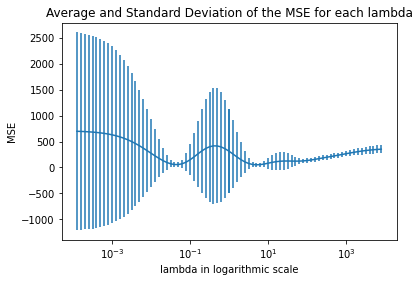

In [ ]:
MSE_average, MSE_sd, lambda_L = cross_valid(phi,y_T)
plt.errorbar(lambda_L,MSE_average, yerr = MSE_sd)
plt.title('Average and Standard Deviation of the MSE for each lambda')
plt.ylabel('MSE')
plt.xlabel('lambda in logarithmic scale')
plt.xscale('log')
plt.show()


### iii) Getting best performing lambda in there

In [ ]:
np.shape(y_T)


(200,)

the lambda with the minimal MSE average is lambda = 5.011872336272724


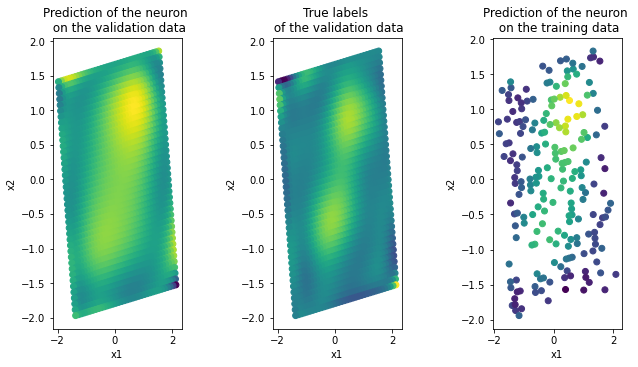

In [ ]:
lambda_best = lambda_L[MSE_average.index(min(MSE_average))]
print('the lambda with the minimal MSE average is lambda = '+ str(lambda_best))

# computing the best weight with the best lambda
I = np.identity(len(phi))
w_star_reg = np.dot(LA.inv(np.dot(phi,phi.T)+ lambda_best*I),np.dot(phi,y_T.T))

#getting the neuron's prediction on the training and validation data
y_reg = prediction_function(w_star_reg,phi_v)
y_train_reg = prediction_function(w_star_reg,phi)

fig,ax = plt.subplots(ncols = 3, figsize=[10,6])
fig.tight_layout(pad =6)

ax[0].scatter(x_s_v[0],x_s_v[1], c = y_reg)
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')
ax[0].set_title('Prediction of the neuron \n on the validation data')

ax[1].scatter(x_s_v[0],x_s_v[1], c = y_v)
ax[1].set_xlabel('x1')
ax[1].set_ylabel('x2')
ax[1].set_title('True labels \n of the validation data')

ax[2].scatter(x_s[0],x_s[1], c = y_train_reg)
ax[2].set_xlabel('x1')
ax[2].set_ylabel('x2')
ax[2].set_title('Prediction of the neuron \n on the training data')

plt.show()



The neuron is now performing worse on the training data (even though it is still pretty good) and better on the validation data : There is less overfitting

## D) Regularization on validation dataset

### i) Running the cross validation on validation data

1476
147


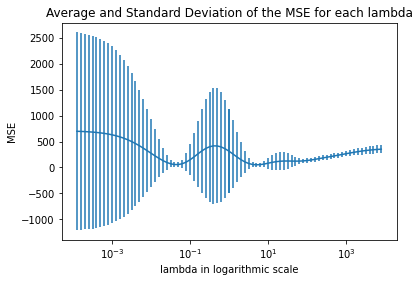

In [ ]:
MSE_average_v, MSE_sd_v, lambda_L_v = cross_valid(phi_v, y_T_v)
plt.errorbar(lambda_L_v, MSE_average, yerr= MSE_sd)
plt.title('Average and Standard Deviation of the MSE for each lambda')
plt.ylabel('MSE')
plt.xlabel('lambda in logarithmic scale')
plt.xscale('log')
plt.show()


### ii) Plotting using the best lambda (from cross validation) against the validation dataset itself.

the lambda with the minimal MSE average is lambda = 0.01995262314968879


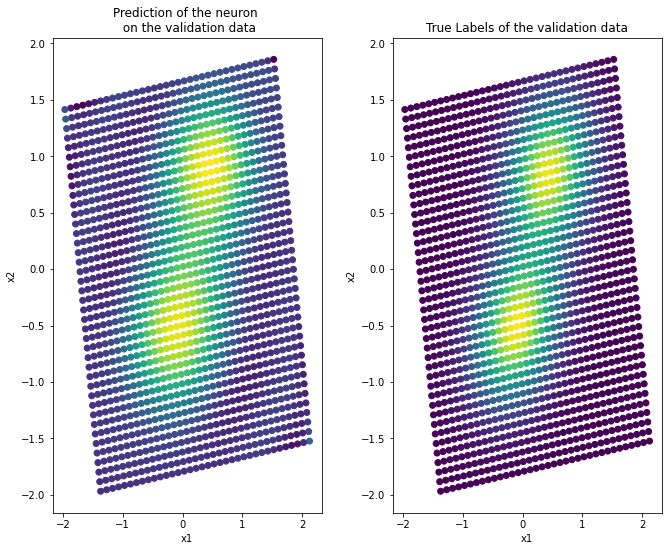

In [ ]:
lambda_best_v = lambda_L_v[MSE_average_v.index(min(MSE_average_v))]

print('the lambda with the minimal MSE average is lambda = '+ str(lambda_best_v))

# computing the best weight with the best lambda
I = np.identity(len(phi_v))
w_star_reg_v = np.dot(LA.inv(np.dot(phi_v,phi_v.T)+ lambda_best_v*I),np.dot(phi_v,y_T_v.T))

#getting the neuron's prediction on the training and validation data
y_reg_v = prediction_function(w_star_reg_v, phi_v)
y_train_reg_v = prediction_function(w_star_reg_v, phi)

fig,ax = plt.subplots(ncols = 2, figsize=[10,8])
fig.tight_layout(pad =4)

ax[0].scatter(x_s_v[0],x_s_v[1], c = y_reg_v)
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')
ax[0].set_title('Prediction of the neuron \n on the validation data')

ax[1].scatter(x_s_v[0],x_s_v[1], c = y_T_v)
ax[1].set_xlabel('x1')
ax[1].set_ylabel('x2')
ax[1].set_title('True Labels of the validation data')


plt.show()



The performance of the neuron on the data it trained on (the original validation data ) is very good

## E) Comparison between the two best lambdas (from training data vs from validation data)

- 

In [ ]:
print('the best lambda with a cross-validation on the training data is  '+ str(lambda_best))
print('the best lambda with a cross-validation on the validation data is  '+ str(lambda_best_v))


the best lambda with a cross-validation on the training data is  5.011872336272724
the best lambda with a cross-validation on the validation data is  0.01995262314968879


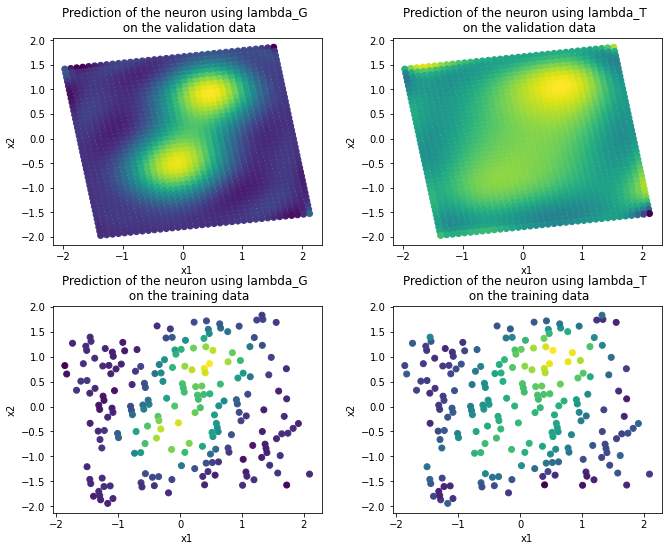

In [ ]:
fig,ax = plt.subplots(ncols = 2,nrows=2, figsize=[10,8])
fig.tight_layout(pad =4)

ax[0,0].scatter(x_s_v[0],x_s_v[1], c = y_reg_v)
ax[0,0].set_xlabel('x1')
ax[0,0].set_ylabel('x2')
ax[0,0].set_title('Prediction of the neuron using lambda_G \n on the validation data')

ax[0,1].scatter(x_s_v[0],x_s_v[1], c = y_reg)
ax[0,1].set_xlabel('x1')
ax[0,1].set_ylabel('x2')
ax[0,1].set_title('Prediction of the neuron using lambda_T \n on the validation data')

ax[1,0].scatter(x_s[0],x_s[1], c = y_train_reg_v)
ax[1,0].set_xlabel('x1')
ax[1,0].set_ylabel('x2')
ax[1,0].set_title('Prediction of the neuron using lambda_G \n on the training data')

ax[1,1].scatter(x_s[0],x_s[1], c = y_train_reg)
ax[1,1].set_xlabel('x1')
ax[1,1].set_ylabel('x2')
ax[1,1].set_title('Prediction of the neuron using lambda_T \n on the training data')

plt.show()

The neuron performs best on the training data and the validation with the second function and lambda_G because there was a lot more data to train on and it is  better to use most ofthe data for training and not for the validation